## Import Modules

In [28]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
from pathlib import Path
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## Set Configs

In [29]:
# Paths
DETR_PATH = '/working/detr'
DATA_PATH = './data/'
MODEL_PATH = '/working/'
IMG_SAVE_PATH = '/working/'

# PyTorch variables
SEED = 42
NUM_CLASSES = 5 # ball + goalkeeper + player + referee + background = 5 classes
BATCH_SIZE = 16
LR = 2e-5

FOLD_NUM = 5
EPOCHS = 20

NULL_CLASS_COEF = 0.5
THRESHOLD = 0.3 # Threshold for bbox prediction score

## Import DETR Modules
Note: when downloading DETR for the first time, may need to change every import from `util` to `detr.util`.

In [30]:
if os.path.exists(DETR_PATH) == False:
    !git clone https://github.com/facebookresearch/detr.git

import sys
sys.path.append(DETR_PATH)

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

fatal: destination path 'detr' already exists and is not an empty directory.


## Define Helper Functions

In [31]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed
seed_everything(SEED)
 

    
def load_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def group_bboxes(df):
    df_ = df.copy()
    df_['bbox_count'] = 1
    df_ = df_.groupby(['filename', 'class']).count().reset_index()
    return_df = df_[['filename', 'class', 'bbox_count']]
    return return_df


def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        normalized_bboxes.append(normalized_bbox)
    return normalized_bboxes


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes


def show_validation_score(train_loss_list, valid_loss_list, save=True, save_dir=IMG_SAVE_PATH, save_name='objectdetection_validation_score.png'):
    fig = plt.figure(figsize=(10,10))
    for i in range(FOLD_NUM):
        train_loss = train_loss_list[i]
        valid_loss = valid_loss_list[i]
        
        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM)), math.ceil(np.sqrt(FOLD_NUM)), i+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
    
    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

## Load and Reshape Training Data

In [32]:
train_df = pd.read_csv(DATA_PATH + '/train_annotations.csv')
train_df['w'] = train_df['xmax'] - train_df['xmin']
train_df['h'] = train_df['ymax'] - train_df['ymin']
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,w,h
0,cd987c_9_8_png.rf.005a880c2a0e49fcb5af3fde350e...,1920,1080,player,707,412,720,447,13,35
1,cd987c_9_8_png.rf.005a880c2a0e49fcb5af3fde350e...,1920,1080,player,1094,419,1119,456,25,37
2,cd987c_9_8_png.rf.005a880c2a0e49fcb5af3fde350e...,1920,1080,player,520,458,535,507,15,49
3,cd987c_9_8_png.rf.005a880c2a0e49fcb5af3fde350e...,1920,1080,referee,770,463,794,508,24,45
4,cd987c_9_8_png.rf.005a880c2a0e49fcb5af3fde350e...,1920,1080,player,805,415,822,449,17,34


In [33]:
train_grouped_df = group_bboxes(train_df)
NUM_QUERIES = max(train_grouped_df['bbox_count']) # How many bboxes shall the model output per image.
train_grouped_df.head()

,filename,class,bbox_count
0,08fd33_0_1_png.rf.59954a0e7db57cb7481c52f01f71...,ball,1
1,08fd33_0_1_png.rf.59954a0e7db57cb7481c52f01f71...,goalkeeper,2
2,08fd33_0_1_png.rf.59954a0e7db57cb7481c52f01f71...,player,20
3,08fd33_0_1_png.rf.59954a0e7db57cb7481c52f01f71...,referee,3
4,08fd33_0_2_png.rf.6ea0cb4069331b557328bb65caa8...,ball,1


## Define Model Components
### Define Image Transformation and Augmentation

In [34]:
class CustomCutout(A.ImageOnlyTransform):
    def __init__(self, num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, always_apply=False, p=0.5):
        super(CustomCutout, self).__init__(always_apply, p)
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size
        self.fill_value = fill_value

    def apply(self, image, **params):
        h, w = image.shape[:2]
        for _ in range(self.num_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.max_h_size // 2, 0, h)
            y2 = np.clip(y + self.max_h_size // 2, 0, h)
            x1 = np.clip(x - self.max_w_size // 2, 0, w)
            x2 = np.clip(x + self.max_w_size // 2, 0, w)
            image[y1:y2, x1:x2] = self.fill_value
        return image


# Image Transformation & Augmentation
def transform_train():
    transforms = [
        #A.RandomResizedCrop(512,512,p=1),
        A.Resize(540, 960, p=1),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
        ], p=0.9),
        A.ToGray(p=0.01),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        CustomCutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),   
        ToTensorV2(p=1)
    ]
    bbox_params = A.BboxParams(format='coco', min_area=0, min_visibility=0, label_fields=['labels'])
    return A.Compose(transforms, bbox_params, p=1)


# Validation images undergo only resizing.
def transform_valid():
    transforms = [
        A.Resize(540,960,p=1),
        ToTensorV2(p=1)
    ]
    bbox_params = A.BboxParams(format='coco', min_area=0, min_visibility=0,label_fields=['labels'])
    return A.Compose(transforms, bbox_params, p=1)

### Define the Dataset

In [35]:
# Dataset
class FootballDataset(Dataset):
    def __init__(self, filenames, dataframe, data_root, transforms=None):
        super().__init__()
        self.filenames = filenames
        self.dataframe = dataframe
        self.data_root = data_root
        self.transforms = transforms

    def __len__(self):
        return self.filenames.shape[0]
    
    def __getitem__(self, index):
        # print("step1")
        filename = self.filenames[index]
        # print("step1")
        records = self.dataframe[self.dataframe['filename'] == filename]
        # Load images
        # print("Load")
        image  = load_img(f'{self.data_root}{filename}').astype(np.float32)
        image /= 255.0 # normalization

        # bbox and area
        # print("box and area")
        boxes = records[['xmin', 'ymin', 'w', 'h']].to_numpy()
        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = np.zeros(len(boxes), dtype=np.int32)

        # Transform images
        # print("transform")
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
        
        # Normalizing bboxes
        # print("normalize")
        _,h,w = image.shape
        boxes = normalize_bbox(sample['bboxes'],rows=h,cols=w)
        
        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.long)
        target['filename'] = torch.tensor([index])
        target['area'] = area

        return image, target, filename

### Define the DataLoader

In [36]:
def collate_fn(batch):
    return tuple(zip(*batch))


def create_dataloader(df, marking, trn_idx, val_idx):
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    train_datasets = FootballDataset(train_['filename'].to_numpy(), marking, DATA_PATH+'train/', transforms=transform_train())
    valid_datasets = FootballDataset(valid_['filename'].to_numpy(), marking, DATA_PATH+'train/', transforms=transform_valid())

    # DataLoader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=True)
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=False)

    return train_loader, valid_loader

### Define Model

In [37]:
class DETRModel(nn.Module):
    def __init__(self):
        super(DETRModel,self).__init__()
        self.num_classes = NUM_CLASSES
        self.num_queries = NUM_QUERIES
        
        # Donwload pre-trained model
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,imgs):
        return self.model(imgs)

In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Run Training
### Cross-Validation

In [ ]:
VALIDATION = False # Set to True to execute
if VALIDATION:    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f'Using {device} device')

    # Cross-validation
    folds = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)\
            .split(np.arange(train_grouped_df.shape[0]), train_grouped_df['filename'].to_numpy())

    # For Visualization
    train_loss_list = []
    valid_loss_list = []

    for fold, (trn_idx, val_idx) in enumerate(folds):     
        print(f'==========Cross-Validation Fold {fold+1}==========')   
        # Define matcher, weight, and loss. 
        # See https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/models/detr.py#L304
        matcher = HungarianMatcher()
        weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
        losses = ['labels', 'boxes', 'cardinality']

        # Load Data
        train_loader, valid_loader = create_dataloader(train_grouped_df, train_df, trn_idx, val_idx)

        # Load model, loss function, and optimizing algorithm
        model = DETRModel().to(device)
        criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses).to(device) # eos_coef is used in the output layer to affect the output corresponding to the absence of an object.
        optimizer = optim.Adam(model.parameters(), lr=LR)
                
        # For Visualization
        train_losses = []
        valid_losses = []

        # Start training
        best_loss = 10**5
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'==========Epoch {epoch+1} Start Training==========')
            model.train()
            train_loss = AverageMeter()
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (imgs, targets, filenames) in pbar:
                img_list = list(img.to(device) for img in imgs)
                targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
                
                output = model(img_list)
                
                loss_dict = criterion(output, targets)
                weight_dict = criterion.weight_dict

                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                train_loss.update(losses.item(), BATCH_SIZE)         

            print(f'==========Epoch {epoch+1} Start Validation==========')
            
            with torch.no_grad():
                valid_loss = AverageMeter() 
                preds = []
                pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                for step, (imgs, targets, filenames) in pbar:
                    img_list = list(img.to(device) for img in imgs)
                    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

                    output = model(img_list)

                    loss_dict = criterion(output, targets)
                    weight_dict = criterion.weight_dict

                    val_losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
                    valid_loss.update(val_losses.item(), BATCH_SIZE)

            # print results from this epoch
            exec_t = int((time.time() - time_start)/60)
            print(
                f'Epoch : {epoch+1} - loss : {train_loss.avg:.4f} - val_loss : {valid_loss.avg:.4f} / Exec time {exec_t} min\n'
            )

            # For visualization
            train_losses.append(train_loss.avg)
            valid_losses.append(valid_loss.avg)
        
        train_loss_list.append(train_losses)
        valid_loss_list.append(valid_losses)
        del model, optimizer, train_loader, valid_loader, train_losses, valid_losses
        gc.collect()
        torch.cuda.empty_cache()

    show_validation_score(train_loss_list, valid_loss_list)
else:
    print("Skipping Validation")

## Train on All Data

In [39]:
TRAIN_ALL = True

EPOCHS = 15 # Adjusted based on cross-validation

if TRAIN_ALL:
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f'Using {device} device')

    matcher = HungarianMatcher()
    weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']
        
    # Load Data
    train_datasets = FootballDataset(train_grouped_df['filename'].to_numpy(), train_df, DATA_PATH+'train/', transforms=transform_train())
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=True)

    # Load model, loss function, and optimizing algorithm
    model = DETRModel().to(device)
    criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
            
    # Start training
    best_loss = 10**5
    for epoch in range(EPOCHS):
        time_start = time.time()
        print(f'==========Epoch {epoch+1} Start Training==========')
        model.train()
        criterion.train()
        train_loss = AverageMeter()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, (imgs, targets, filenames) in pbar:
            img_list = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
            
            output = model(img_list)
            
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()  

            train_loss.update(losses.item(), BATCH_SIZE)      

        # print result from this epoch
        exec_t = int((time.time() - time_start)/60)
        print(
            f'Epoch : {epoch+1} - loss : {train_loss.avg:.4f} / Exec time {exec_t} min\n'
        )    

    print(f'Save model trained with all data')
    os.makedirs(MODEL_PATH, exist_ok=True)
    torch.save(model.state_dict(), MODEL_PATH+'objectdetection.pth')           

    del model, optimizer, train_loader
    gc.collect()
    torch.cuda.empty_cache()
else:
    print("Skipping Training on All Data")

Using cuda device


Using cache found in C:\Users\kitch/.cache\torch\hub\facebookresearch_detr_main
c:\Users\kitch\Desktop\Computer Vision\Final\finaltransfer\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kitch\Desktop\Computer Vision\Final\finaltransfer\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==========Epoch 1 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.8164 / Exec time 0 min

==========Epoch 2 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1947 / Exec time 0 min

==========Epoch 3 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.0486 / Exec time 0 min

==========Epoch 4 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.8984 / Exec time 0 min

==========Epoch 5 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8451 / Exec time 0 min

==========Epoch 6 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.8059 / Exec time 0 min

==========Epoch 7 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.8015 / Exec time 0 min

==========Epoch 8 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.7911 / Exec time 0 min

==========Epoch 9 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.8068 / Exec time 0 min

==========Epoch 10 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.7868 / Exec time 0 min

==========Epoch 11 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.7668 / Exec time 0 min

==========Epoch 12 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.7562 / Exec time 0 min

==========Epoch 13 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.8734 / Exec time 0 min

==========Epoch 14 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.7642 / Exec time 1 min

==========Epoch 15 Start Training==========


  0%|          | 0/45 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.7346 / Exec time 1 min

Save model trained with all data


## Predict on Test Data

In [23]:
PREDICT = True

In [40]:
def transform_test():
    transforms = [
        A.Resize(540,960,p=1),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)


class FootballTestDataset(Dataset):
    def __init__(self, filnames, data_root, transforms=None):
        super().__init__()
        self.filenames = filnames
        self.data_root = data_root
        self.transforms = transforms

    def __len__(self):
        return self.filenames.shape[0]
    
    def __getitem__(self, index):
        filename = self.filenames[index][:-4]
        # Load images
        image  = load_img(f'{self.data_root}{filename}.jpg').astype(np.float32)
        image /= 255.0 # normalization

        # Transform images
        if self.transforms:
            # image = self.transforms(image)['image']
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image, filename

In [50]:
if PREDICT:
    pred_columns = ['filename', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']
    predictions_df = pd.DataFrame(columns=pred_columns)
    image_id_list = np.array(os.listdir(DATA_PATH+'test/'))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    print(f'Using {device} device')

    # Load Data
    test_datasets = FootballTestDataset(image_id_list, DATA_PATH+'test/', transforms=transform_test())

    # Data Loader
    test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0, shuffle=False)

    # Load model
    model = DETRModel().to(device)
    model.load_state_dict(torch.load(MODEL_PATH+'objectdetection.pth'))

    # Start Inference
    print(f'==========Start Inference==========')
    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (imgs, image_ids) in pbar:
            img_list = list(img.to(device) for img in imgs)
            output = model(img_list)
            for i, image_id in enumerate(image_ids):
                prediction_scores = output['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
                predicted_boxes = output['pred_boxes'][i].detach().cpu().numpy()

                # _, h, w = imgs[0].shape
                h,w,_ = load_img(f'{DATA_PATH}test/{image_id}.jpg').shape # height, width, color of origianl image
                denormalized_boxes = denormalize_bbox(predicted_boxes, rows=h, cols=w)

                for box, p in zip(denormalized_boxes, prediction_scores):
                    if p > THRESHOLD:
                        score = p
                        filename = image_id + ".jpg"
                        xmin = int(box[0])
                        ymin = int(box[1])
                        xmax = xmin + int(box[2])
                        ymax = ymin + int(box[3])
                        predictions_df.loc[len(predictions_df)] = {'filename': filename, 'confidence': score, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}
    print(predictions_df.head())
    predictions_df.to_csv('predictions.csv', index=False)
else:
    print("Skipping Prediction")

Using cuda device


Using cache found in C:\Users\kitch/.cache\torch\hub\facebookresearch_detr_main
c:\Users\kitch\Desktop\Computer Vision\Final\finaltransfer\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kitch\Desktop\Computer Vision\Final\finaltransfer\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


==========Start Inference==========


  0%|          | 0/1 [00:00<?, ?it/s]

                                            filename  confidence  xmin  ymin  \
0  40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd9...    0.957541   990   410   
1  40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd9...    0.856081   686   373   
2  40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd9...    0.791837   386   370   
3  40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd9...    0.986005  1279   540   
4  40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd9...    0.798849   787   618   

   xmax  ymax  
0  1008   445  
1   704   405  
2   399   399  
3  1303   591  
4   815   680  


## Visualize

Prediction for image 5 of 13


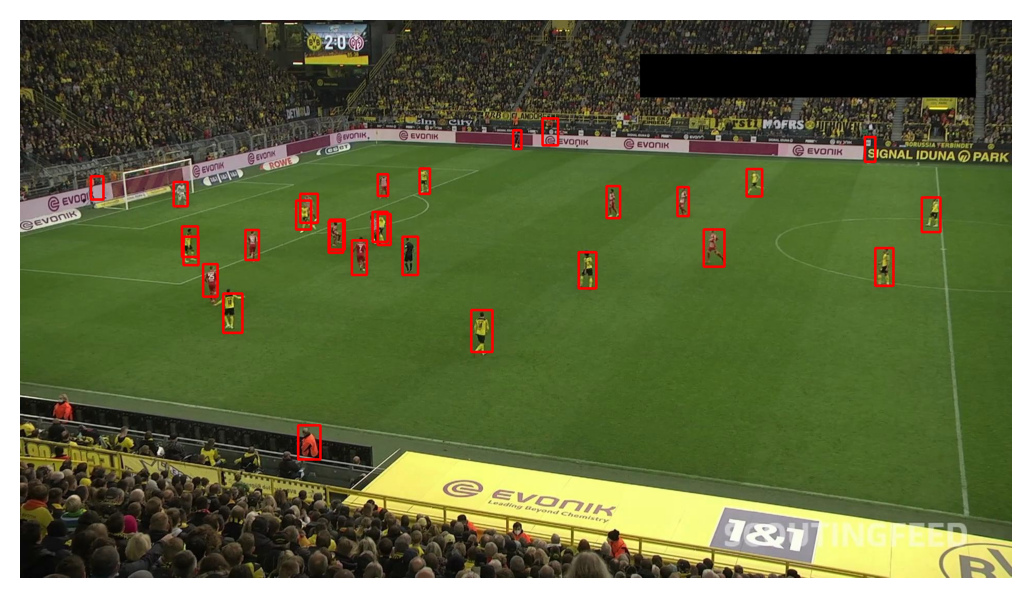

In [53]:
VISUALIZE = True
if VISUALIZE:
    unique_files = predictions_df['filename'].unique()
    if len(unique_files) == 0:
        print("No predictions to display.")
    else:
        i = 4 # Choose a test images with index 0-12 to display
        print("Prediction for image " + str(i + 1) + " of " + str(len(unique_files)))
        target_file = unique_files[i]
        img = load_img(DATA_PATH + 'test/' + target_file).copy()

        # Filter the predictions DataFrame for the current image
        image_predictions = predictions_df[predictions_df['filename'] == target_file]

        # Iterate over rows in the filtered DataFrame to draw bounding boxes
        for index, row in image_predictions.iterrows():
            xmin = int(row['xmin'])
            ymin = int(row['ymin'])
            xmax = int(row['xmax'])
            ymax = int(row['ymax'])

            cv2.rectangle(img,
                            (xmin, ymin),
                            (xmax, ymax),
                            [255, 0, 0], 3)  # Blue color in BGR

        plt.imshow(img)
        plt.axis('off')  # Hide axes to better display the image
        plt.show()
else:
    print("Skipping Visualization")

## Analyze Performance

In [51]:
ANALYZE = True

# Function to calculate the Intersection over Union (IoU)
def calculate_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    # Sort the boxes by confidence
    pred_boxes = sorted(pred_boxes, key=lambda x: x[0], reverse=True)
    true_positives = np.zeros(len(pred_boxes))
    false_positives = np.zeros(len(pred_boxes))
    
    # Create a list to mark which ground-truth boxes have been detected
    detected_gt = []

    # Loop over all predicted boxes
    for i, pred_box in enumerate(pred_boxes):
        # Loop over all ground truth boxes
        best_iou = 0
        best_gt_idx = -1
        for j, gt_box in enumerate(gt_boxes):
            iou = calculate_iou(pred_box[1:], gt_box)

            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        # Check if the IoU is above the threshold and the ground-truth has not been detected already
        if best_iou > iou_threshold:
            if best_gt_idx not in detected_gt:
                true_positives[i] = 1
                detected_gt.append(best_gt_idx)
            else:
                false_positives[i] = 1
        else:
            false_positives[i] = 1

    # Calculate precision and recall
    tp_sum = np.sum(true_positives)
    fp_sum = np.sum(false_positives)
    fn_sum = len(gt_boxes) - tp_sum  # Calculating false negatives as ground truth boxes not detected as true positives
    
    precision = tp_sum / (tp_sum + fp_sum) if tp_sum + fp_sum > 0 else 0
    recall = tp_sum / (tp_sum + fn_sum) if tp_sum + fn_sum > 0 else 0
    
    return precision, recall

In [52]:
if ANALYZE:
    # Load the actual bounding boxes CSV
    actual_bb_path = r'.\data\test_annotations.csv'
    actual_bb_df = pd.read_csv(actual_bb_path)

    grouped_actual_bb = actual_bb_df.groupby('filename')
    grouped_predicted_bb = predictions_df.groupby('filename')

    # Compute precision, recall
    precision_recall = []
    # For each image
    for filename, group in grouped_predicted_bb:
        # If the filename exists in the actual bounding box dataframe
        if filename in grouped_actual_bb.groups:
            gt_boxes = grouped_actual_bb.get_group(filename)[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
            pred_boxes = group[['confidence', 'xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
            precision, recall = compute_precision_recall(gt_boxes, pred_boxes)
            precision_recall.append((precision, recall))
else:
    precision_recall = None
    print("Skipping Analysis")

precision_recall

[(0.6666666666666666, 0.8333333333333334),
 (0.5517241379310345, 0.6666666666666666),
 (0.5714285714285714, 0.6956521739130435),
 (0.5862068965517241, 0.68),
 (0.6896551724137931, 0.8333333333333334),
 (0.7272727272727273, 0.6666666666666666),
 (0.7037037037037037, 0.7916666666666666),
 (0.6785714285714286, 0.7916666666666666),
 (0.64, 0.6666666666666666),
 (0.5769230769230769, 0.7142857142857143),
 (0.5357142857142857, 0.625),
 (0.8095238095238095, 0.68),
 (0.6923076923076923, 0.75)]

## Attention Visualizer

In [54]:
import math

import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [55]:
import torchvision.transforms as T
transform = T.Compose([
    T.Resize((540, 960)),
    T.ToTensor(),
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [56]:
im = Image.open('./data/test/4b770a_3_6_png.rf.d0d9403f2f73ca0da7a6a1373c02b749.jpg')
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0).to(device)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > THRESHOLD

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

In [57]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

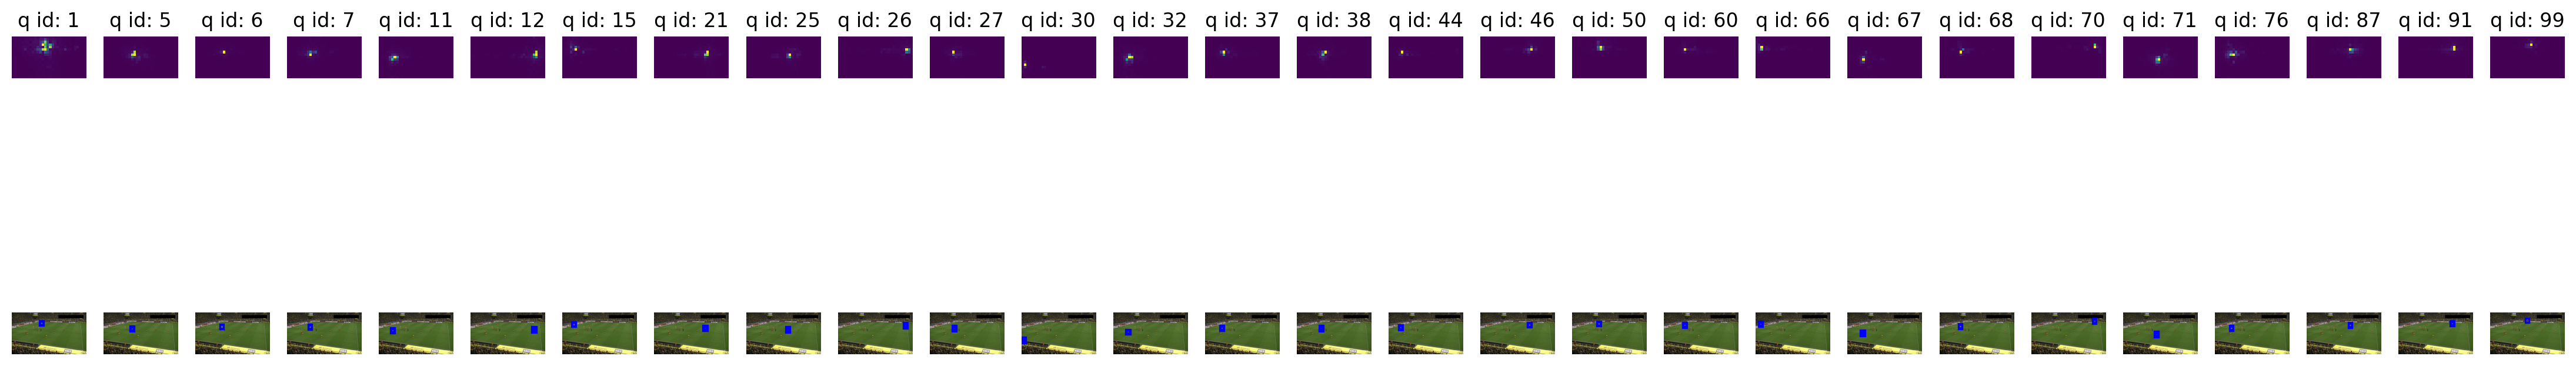

In [58]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].cpu().view(h, w))
    ax.axis('off')
    ax.set_title(f'q id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin.cpu().numpy(), ymin.cpu().numpy()), xmax.cpu().numpy() - xmin.cpu().numpy(), ymax.cpu().numpy() - ymin.cpu().numpy(),
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title('')
fig.tight_layout()

## Sources

Official DETR Release:
https://github.com/facebookresearch/detr

Hands-on tutorial for DETR:
https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

Soccer Dataset:
https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc

Example use of DETR on a different dataset (some functions were modified to adapt to the soccer dataset):
https://www.kaggle.com/code/shnakazawa/object-detection-with-pytorch-and-detr/notebook#References